# Combining LabView BCS with Bluesky

## Overview

This notebook demonstrates how the LabView Beamline Control System API can be used to implement a "Trajectory Scan" as an `ophyd` device. Furthermore, this "Trajectory Scan" device can be initiated by the `bluesky` Run Engine as a `fly` plan with data avaliable in a bluesky run document.

### Brief Summary

The bluesky `fly` plan will cede control to an `ophyd` "[Fly-able Interface](http://nsls-ii.github.io/ophyd/architecture.html#fly-able-interface)" (e.g., [FlyerInterface](https://github.com/bluesky/ophyd/blob/dd4b3e389a0202ecacce39fc3965d703c616b0d4/ophyd/flyers.py#L17)) to collect data asynchronously, and then return data as "[event](https://blueskyproject.io/event-model/data-model.html#event-document)" documents.

The "Fly-able Interface" must:

1. `kickoff()` the scan
2. `complete()` data collection for the scan
3. `describe_collect()`: provide a descriptor for the data that is being collected
4. `collect()`: yield event document(s) that contain the data

More details about this concept of embedding external control system scans into bluesky can be found in [this example notebook](https://github.com/BCDA-APS/bluesky_training/blob/31-sscan-1D-as-flyer/sscan_1d_flyer.ipynb).

This example uses a _synchronous/blocking_ version of the BCS-API library (BCSz_sync.py), which is otherwise identical to the asynchronous version (BCSz.py). The blocking version was created because the bluesky Run Engine does not currently use `asyncio` `await` directive for the Fly-able interface methods.

## Credits

This example builds heavily upon two recently published works, as well as the many developers and contributors to the bluesky and BCS projects.

* [BCS-API](http://bcsapi.als.lbl.gov:3080): ZeroMQ library and python bindings (BCSz.py) developed by [Damon English](https://github.com/daenglis) for interfacing with the Advanced Light Source's BCS control system.
* [`sscan as 1D Flyer`](https://github.com/BCDA-APS/bluesky_training/blob/31-sscan-1D-as-flyer/sscan_1d_flyer.ipynb) example published by [Pete Jemian](https://github.com/prjemian) to demonstrate how the bluesky fly plan can be used to initiate scans and report data from external control systems (in that case, the EPICS sscan record).

# Prepare the notebook settings

In [1]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib
%matplotlib notebook

In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
try:
    theNotebook
except NameError as e:
    theNotebook = "ALS-DXR-0066_XMCD_06"
    theNotebook

'ALS-DXR-0066_XMCD_06'

In [5]:
import logging
logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)

# Setup bluesky

In [6]:
from bluesky import RunEngine

RE = RunEngine({})

In [7]:
from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
bec_token = RE.subscribe(bec)
bec.enable_table()  # Print hinted readings from the ‘primary’ stream in a LiveTable

# Make plots update live while scans run.
from bluesky.utils import install_kicker
install_kicker()

In [8]:
from dotenv import load_dotenv

load_dotenv()  # import environment variables from .env

True

In [9]:
from databroker import Broker
db = Broker.named('TEST')

# Insert all metadata/data captured into db.
RE.subscribe(db.insert)

1

In [10]:
from bluesky.utils import ProgressBarManager
RE.waiting_hook = ProgressBarManager()

In [11]:
RE.md['notebook'] = theNotebook
RE.md

{'versions': {'ophyd': '1.6.3', 'bluesky': '1.8.1'},
 'notebook': 'ALS-DXR-0066_XMCD_06'}

# Setup motors

## Connected to LabView BCS using EPICS CA protocol

LabView EPICS module needs to be running on `BL402BCS` and no one else must be using the beamline.

Contact Padraic pshafer@lbl.gov before running any scripts below from a computer that can access `BCS402` PVs

In [12]:
import sys
from os.path import dirname, abspath, join
bl402_epics_path = join(dirname(abspath('')), "bl402-epics") 
sys.path.append(bl402_epics_path)
print(bl402_epics_path)

from blue_bcs import motors, counters

C:\experiments\beamline_commissioning\bl402-epics


Unable to import 'fcntl'. Will be unable to lock files


## Get sample position

In [13]:
from blue_bcs.motors import vmm_xyz

In [14]:
vmm_xyz.wait_for_connection(timeout=15.0)
vmm_xyz.read()

OrderedDict([('vmm_stage_x', {'value': 0.501, 'timestamp': 631152000.0}),
             ('vmm_stage_x_user_setpoint',
              {'value': 0.501, 'timestamp': 631152000.0}),
             ('vmm_stage_y', {'value': 7.0, 'timestamp': 631152000.0}),
             ('vmm_stage_y_user_setpoint',
              {'value': 7.0, 'timestamp': 631152000.0}),
             ('vmm_stage_z', {'value': 78.5, 'timestamp': 1635732497.726922}),
             ('vmm_stage_z_user_setpoint',
              {'value': 78.5, 'timestamp': 1635732497.726922}),
             ('vmm_stage_rotation',
              {'value': -30.003, 'timestamp': 631152000.0}),
             ('vmm_stage_rotation_user_setpoint',
              {'value': -30.003, 'timestamp': 631152000.0})])

## Define sample positions

In [15]:
samples = {
    "HEA_39": {
        "z": 38.0
    },
    "HEA_40": {
        "z": 57.5
    },
    "HEO_1": {
        "z": 73.0
    },
    "HEO_2": {
        "z": 78.5
    },
}

# Connect to BCS server

In [16]:
import os
import collections

# import bcs_api
from bcs_api import BCSz, BcsSigFlyScanFlyer, BcsTrajectoryScan, BcsTrajScanFlyer

In [17]:
bl402bcs = BCSz.BCSServer()

bl402bcs.connect(addr=str(os.environ["BCS_SERVER"]), port=int(os.environ["BCS_PORT"]))

Server Public Key b'zTO/M.r1z>7T/dZLw#beAltt3sdg?7R=DvVI9W[u'


### Start the Beamline Scan GUI before running the scan

In [18]:
from bluesky.plans import fly

from matplotlib import pyplot as plt

In [19]:
fly_FlyXmcd = BcsTrajScanFlyer("BCS402:", name="ssflyFlyXmcd")

In [20]:
fly_FlyXmcd.scan_setup(
        bcs_server=bl402bcs, 
        input_file_path=os.path.join(
            str(os.environ["BCS_REMOTE_SCAN_PATH"]),
            "Padraic\\2021-10-27\\Co_XMCD_x4.scn",
            ), 
        subpath_replace_dict=collections.OrderedDict([
            (str(os.environ["BCS_REMOTE_SCAN_PATH"]), str(os.environ["BCS_LOCAL_SCAN_PATH"])),
            ])
    )

In [21]:
fly_FlyXmcd.get()

BcsTrajScanFlyerTuple(input_file_path='C:\\\\experiments\\\\Padraic\\2021-10-27\\Co_XMCD_x4.scn', delay_sec=0.0, count_sec=1.0, num_scans=1, skip_unchanged_motors=True, move_sequentially=False, shift_flying_data=False, final_move='Stay', final_trajectory_name='', memo='', filename_pattern='*.txt', ready=True, busy=False, done=True, execute_scan=True, data_paths='', normal_motors=['Hx', 'EPU Polarization'], flying_motor='Beamline Energy', stream_event_sizes=[1201, 1201, 0, 1201, 1201, 0, 1201, 1201, 0, 1201, 1201, 0], yield_array_events=True)

In [22]:
data_files = list()
normalization_signals = ["I0 BL", "I0 ES", "Clock"]
intensity_signals = ["EY", "LY"]
primary_motor = "Captured Mono Energy"
    
RE(fly(
    [fly_FlyXmcd], 
    md=dict(
        purpose="testing XMCD",
        sample_name="NONE",
        scan_type="flying",
        project="DD-00598-001: Magnetic Interactions in High Entropy Magnetic Systems",
        beamline="4.0.2",
        endstation="VMM",
        tracking="ALS-DXR-0066",
        normalization_signals=normalization_signals,
        intensity_signals=intensity_signals,
        hints={
            "dimensions": [([primary_motor], "primary")],
            "fields": intensity_signals,
        },
    ),
))

INFO:bluesky:Executing plan <generator object fly at 0x0000016FE2CA1040>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'idle' -> 'running'




Transient Scan ID: 1     Time: 2021-10-31 17:51:27
Persistent Unique Scan ID: 'b3caadd6-6e99-4fb1-83ac-5a1839210df4'


INFO:root:complete() starting


Adding new data file
ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
Adding new data file
Adding new data file
Adding new data file
Scan is finshed!


INFO:root:complete() ending


ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
                                                                                                                       
Creating new stream primary
...New event_size = 1201
...Previous stream_event_size = None
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | Captured Mono Energy |
+-----------+------------+----------------------+


C:\experiments\beamline_commissioning\BCS-API\bcs_events.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df[output_col] = datetimes
C:\Users\admin\miniconda3\envs\bluesky\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\admin\miniconda3\envs\bluesky\lib\site-packages\event_model\__init__.py:208: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  warnings.warn(


+-----------+------------+----------------------+
generator fly ['b3caadd6'] (scan num: 1)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x0000016FE2CA1040>


('b3caadd6-6e99-4fb1-83ac-5a1839210df4',)

MoveStatus(done=True, pos=vmm_stage_z, elapsed=34.5, success=True, settle_time=0.0)

INFO:bluesky:Executing plan <generator object fly at 0x0000016FE2E6BAC0>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'idle' -> 'running'




Transient Scan ID: 2     Time: 2021-10-31 18:13:52
Persistent Unique Scan ID: '07380931-2eff-451a-949b-3d97626c106a'


INFO:root:complete() starting


Adding new data file
ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
Adding new data file
Adding new data file
Adding new data file
Scan is finshed!


INFO:root:complete() ending


ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
                                                                                                                       
Creating new stream primary
...New event_size = 1201
...Previous stream_event_size = None
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | Captured Mono Energy |
+-----------+------------+----------------------+
+-----------+------------+----------------------+
generator fly ['07380931'] (scan num: 2)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x0000016FE2E6BAC0>


('07380931-2eff-451a-949b-3d97626c106a',)

False

True

data_file=['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 04.txt']


<IPython.core.display.Javascript object>


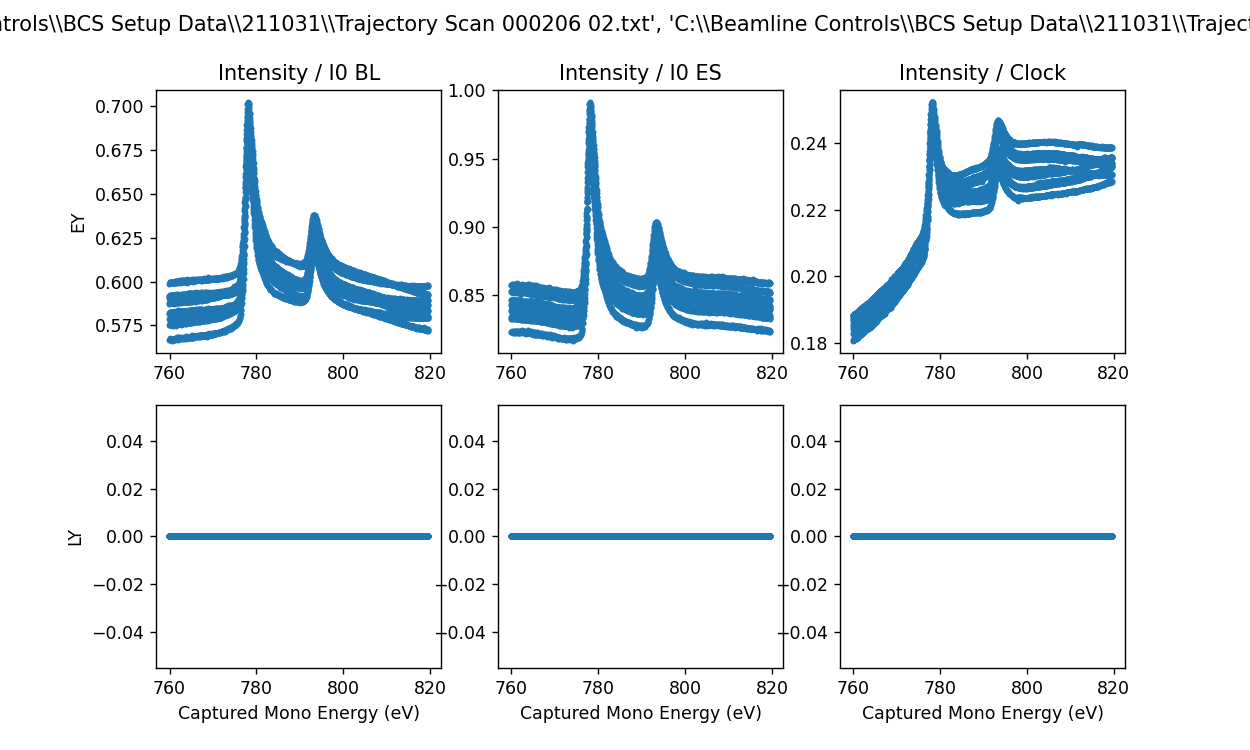

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0, 0.5, 'EY')

Text(0, 0.5, 'LY')

Text(0.5, 1.0, 'Intensity / I0 BL')

Text(0.5, 1.0, 'Intensity / I0 ES')

Text(0.5, 1.0, 'Intensity / Clock')

Text(0.5, 0.98, "Scan# ['C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000206 01.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000206 02.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000206 03.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000206 04.txt']")

MoveStatus(done=True, pos=vmm_stage_z, elapsed=17.7, success=True, settle_time=0.0)

INFO:bluesky:Executing plan <generator object fly at 0x0000016FE2E57F20>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'idle' -> 'running'




Transient Scan ID: 3     Time: 2021-10-31 18:32:05
Persistent Unique Scan ID: '228a4b9a-edb5-4d0e-89c4-e90526332f18'


INFO:root:complete() starting


Adding new data file
ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
Adding new data file
Adding new data file
Adding new data file
Scan is finshed!


INFO:root:complete() ending


ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
                                                                                                                       
Creating new stream primary
...New event_size = 1201
...Previous stream_event_size = None
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | Captured Mono Energy |
+-----------+------------+----------------------+
+-----------+------------+----------------------+
generator fly ['228a4b9a'] (scan num: 3)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x0000016FE2E57F20>


('228a4b9a-edb5-4d0e-89c4-e90526332f18',)

False

True

data_file=['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 04.txt']


<IPython.core.display.Javascript object>


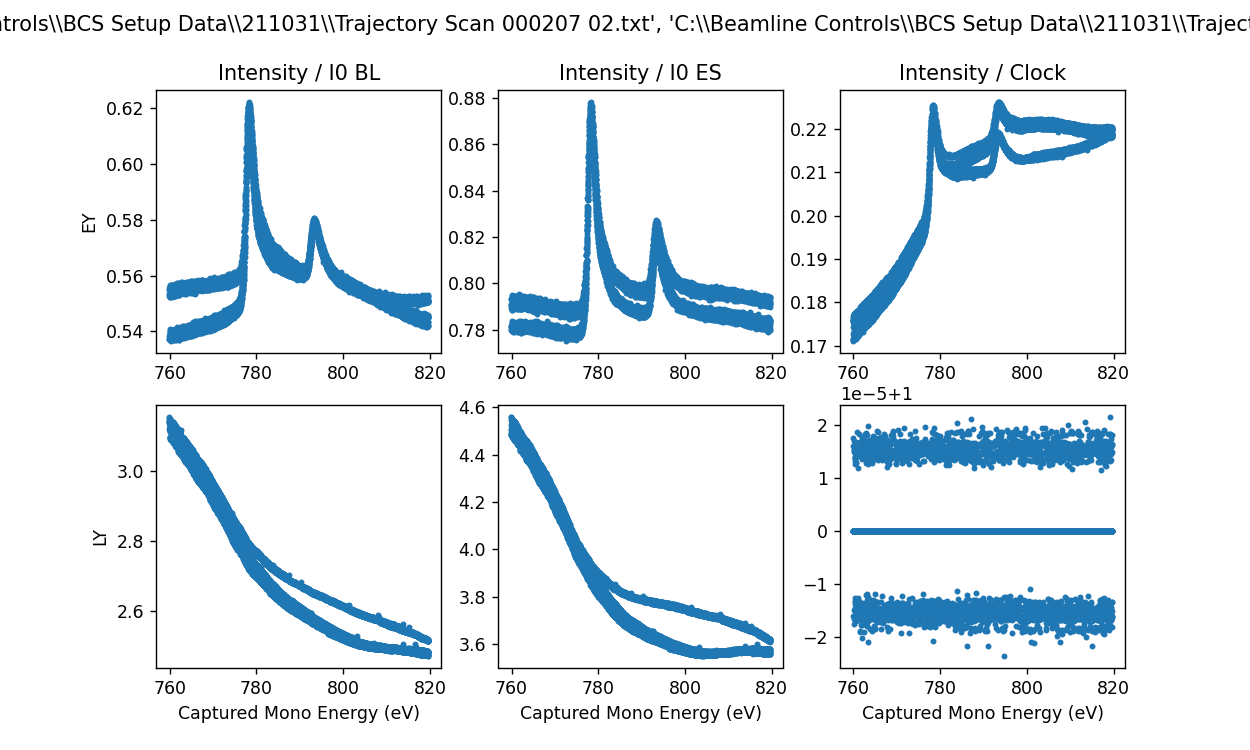

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0, 0.5, 'EY')

Text(0, 0.5, 'LY')

Text(0.5, 1.0, 'Intensity / I0 BL')

Text(0.5, 1.0, 'Intensity / I0 ES')

Text(0.5, 1.0, 'Intensity / Clock')

Text(0.5, 0.98, "Scan# ['C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000207 01.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000207 02.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000207 03.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000207 04.txt']")

MoveStatus(done=True, pos=vmm_stage_z, elapsed=14.5, success=True, settle_time=0.0)

INFO:bluesky:Executing plan <generator object fly at 0x0000016FE607A740>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'idle' -> 'running'




Transient Scan ID: 4     Time: 2021-10-31 18:50:15
Persistent Unique Scan ID: '79e76c58-a100-4f8f-9fc5-981a9cd8600d'


INFO:root:complete() starting


Adding new data file
ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
Adding new data file
Adding new data file
Adding new data file
Scan is finshed!


INFO:root:complete() ending


ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
                                                                                                                       
Creating new stream primary
...New event_size = 1201
...Previous stream_event_size = None
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | Captured Mono Energy |
+-----------+------------+----------------------+
+-----------+------------+----------------------+
generator fly ['79e76c58'] (scan num: 4)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x0000016FE607A740>


('79e76c58-a100-4f8f-9fc5-981a9cd8600d',)

False

True

data_file=['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 04.txt']


<IPython.core.display.Javascript object>


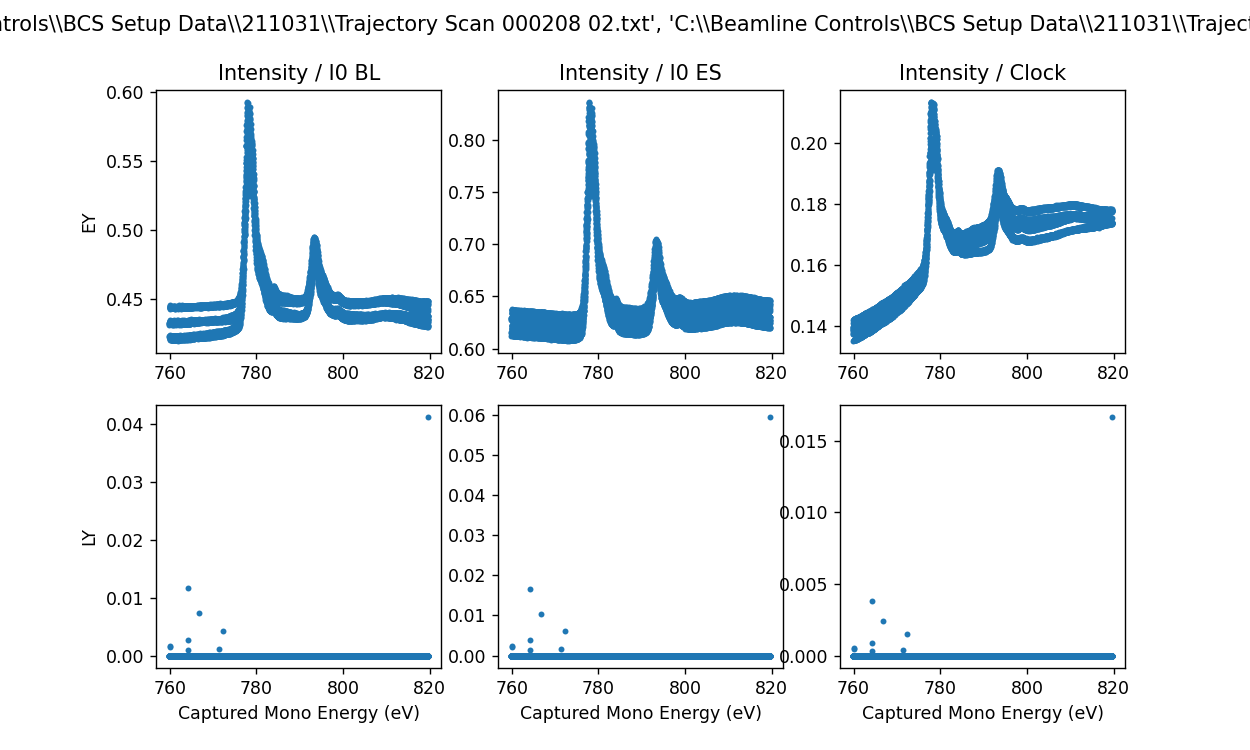

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0, 0.5, 'EY')

Text(0, 0.5, 'LY')

Text(0.5, 1.0, 'Intensity / I0 BL')

Text(0.5, 1.0, 'Intensity / I0 ES')

Text(0.5, 1.0, 'Intensity / Clock')

Text(0.5, 0.98, "Scan# ['C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000208 01.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000208 02.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000208 03.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000208 04.txt']")

MoveStatus(done=True, pos=vmm_stage_z, elapsed=6.4, success=True, settle_time=0.0)

INFO:bluesky:Executing plan <generator object fly at 0x0000016FE607A430>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'idle' -> 'running'




Transient Scan ID: 5     Time: 2021-10-31 19:08:16
Persistent Unique Scan ID: '914a2960-8351-42ed-b641-7df0267ccb6c'


INFO:root:complete() starting


Adding new data file
ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
Adding new data file
Adding new data file
Adding new data file
Scan is finshed!


INFO:root:complete() ending


ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
                                                                                                                       
Creating new stream primary
...New event_size = 1201
...Previous stream_event_size = None
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | Captured Mono Energy |
+-----------+------------+----------------------+
+-----------+------------+----------------------+
generator fly ['914a2960'] (scan num: 5)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x0000016FE607A430>


('914a2960-8351-42ed-b641-7df0267ccb6c',)

False

True

data_file=['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000209 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000209 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000209 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000209 04.txt']


<IPython.core.display.Javascript object>


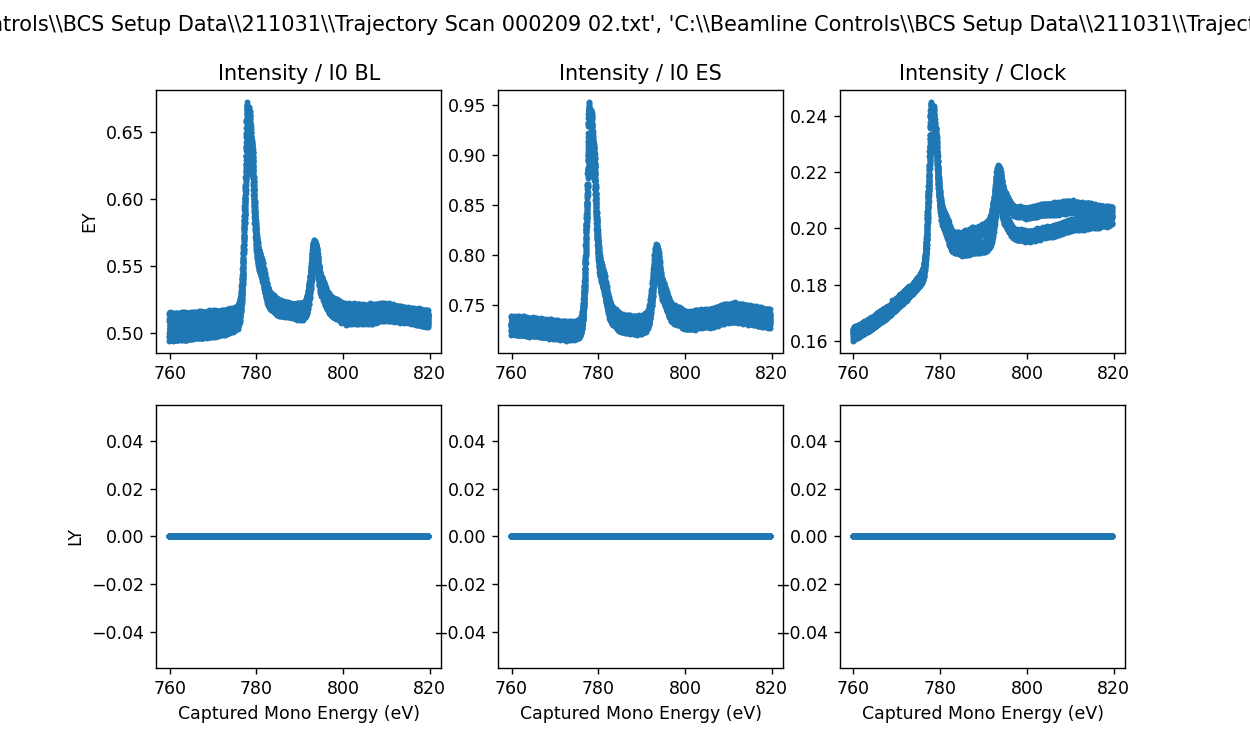

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0, 0.5, 'EY')

Text(0, 0.5, 'LY')

Text(0.5, 1.0, 'Intensity / I0 BL')

Text(0.5, 1.0, 'Intensity / I0 ES')

Text(0.5, 1.0, 'Intensity / Clock')

Text(0.5, 0.98, "Scan# ['C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000209 01.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000209 02.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000209 03.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000209 04.txt']")

data_files=[['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 04.txt'], ['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 04.txt'], ['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 04.txt'], ['C:\\Beamline Control

In [23]:
data_files = list()
normalization_signals = ["I0 BL", "I0 ES", "Clock"]
intensity_signals = ["EY", "LY"]
primary_motor = "Captured Mono Energy"

for sample_name in ["HEA_39", "HEA_40", "HEO_1", "HEO_2"]:

    for coord, value in samples[sample_name].items():
        # print(vmm_xyz.__dict__["_signals"][coord])
        vmm_xyz.__dict__["_signals"][coord].move(value)
    
    RE(fly(
        [fly_FlyXmcd], 
        md=dict(
            purpose="example XMCD vs. sample",
            sample_name=sample_name,
            scan_type="flying",
            project="DD-00598-001: Magnetic Interactions in High Entropy Magnetic Systems",
            beamline="4.0.2",
            endstation="VMM",
            tracking="ALS-DXR-0066",
            normalization_signals=normalization_signals,
            intensity_signals=intensity_signals,
            hints={
                "dimensions": [([primary_motor], "primary")],
                "fields": intensity_signals,
            },
        ),
    ))
    
    fly_FlyXmcd.busy.get()
    fly_FlyXmcd.done.get()
    data_file = fly_FlyXmcd.data_paths.get()
    print(f"{data_file=}")
    
    data_files.append(data_file)
    
    run = db.v2[-1]
    data = run.primary.read()
    
    fig, axes = plt.subplots(nrows=len(intensity_signals), ncols=len(normalization_signals), figsize=(10,6))
    axes_iter = iter(axes.flatten())
    for intensity_signal in intensity_signals:
        for normalization_signal in normalization_signals:

            ax=next(axes_iter)
            ax.scatter(
                x=data[primary_motor], 
                y=data[intensity_signal] / data[normalization_signal], 
                linestyles='-', 
                linewidths=2,
                s=2,
                )
    for ax in axes[-1]:
        ax.set_xlabel(f"{primary_motor} (eV)") # Assume energy units
    for (ax, signal) in zip(axes[:, 0], intensity_signals):
        ax.set_ylabel(f"{signal}")
    for (ax, norm_signal) in zip(axes[0], normalization_signals):
        ax.set_title(f"Intensity / {norm_signal}")
    fig.suptitle(f'Scan# {data_file}')
    plt.show()

print(f"{data_files=}")

# Which control layer is ophyd using

In [24]:
from ophyd import cl

cl

namespace(setup=<function ophyd._pyepics_shim.setup(logger)>,
          caput=<function epics.caput(pvname, value, wait=False, timeout=60.0, connection_timeout=5.0)>,
          caget=<function epics.caget(pvname, as_string=False, count=None, as_numpy=True, use_monitor=True, timeout=5.0, connection_timeout=5.0)>,
          get_pv=<function epics.pv.get_pv(pvname, form='time', connect=False, context=None, timeout=5.0, connection_callback=None, access_callback=None, callback=None, verbose=False, count=None, auto_monitor=None)>,
          thread_class=epics.ca.CAThread,
          name='pyepics',
          release_pvs=<function ophyd._pyepics_shim.release_pvs(*pvs)>,
          get_dispatcher=<function ophyd._pyepics_shim.get_dispatcher()>)

# Magnetic Hysteresis Loops (Flying Scans)

In [18]:
from dotenv import load_dotenv

load_dotenv()  # import environment variables from .env

True

## Get Beamline Energy

In [19]:
from blue_bcs.motors import epu, mono

In [20]:
epu.wait_for_connection(timeout=15.0)
epu.read()

OrderedDict([('epu_energy', {'value': 760.0, 'timestamp': 1635743326.432816}),
             ('epu_energy_user_setpoint',
              {'value': 760.0360000000001, 'timestamp': 1635741226.337041}),
             ('epu_polarization',
              {'value': 0.9, 'timestamp': 1635733564.091301}),
             ('epu_polarization_user_setpoint',
              {'value': 0.9, 'timestamp': 1635733564.091301}),
             ('epu_gap', {'value': 23.34, 'timestamp': 1635741227.026663}),
             ('epu_gap_user_setpoint',
              {'value': 23.34, 'timestamp': 1635741227.026663}),
             ('epu_z', {'value': 11.157, 'timestamp': 1635742518.375944}),
             ('epu_z_user_setpoint',
              {'value': 11.157, 'timestamp': 1635742518.375944}),
             ('epu_harmonic', {'value': 3.0, 'timestamp': 631152000.0}),
             ('epu_harmonic_user_setpoint',
              {'value': 3.0, 'timestamp': 631152000.0}),
             ('epu_soft_limit', {'value': 3.0, 'timestamp': 63

In [21]:
mono.wait_for_connection(timeout=15.0)
mono.read()

OrderedDict([('mono_energy',
              {'value': 759.998, 'timestamp': 1635743363.16884}),
             ('mono_energy_user_setpoint',
              {'value': 759.975, 'timestamp': 1635742833.37836}),
             ('mono_grating',
              {'value': 28042.62, 'timestamp': 1635743362.19621}),
             ('mono_grating_user_setpoint',
              {'value': 28042.86, 'timestamp': 1635742833.408269}),
             ('mono_premirror',
              {'value': 25820.97, 'timestamp': 1635743364.111301}),
             ('mono_premirror_user_setpoint',
              {'value': 25821.02, 'timestamp': 1635742833.318594}),
             ('mono_jack', {'value': -937.15, 'timestamp': 1635743362.375867}),
             ('mono_jack_user_setpoint',
              {'value': -937.23, 'timestamp': 1635742812.517819}),
             ('mono_transverse',
              {'value': 40500.782, 'timestamp': 631152000.0}),
             ('mono_transverse_user_setpoint',
              {'value': 40500.782, 'timest

## Define energies for loops

In [22]:
sample_energies = {
    "HEA_39": {
        "Fe": 707.25,
        "Co": 777.95,
        "Ni": 852.25,
        },
    "HEA_40": {
        "Cr": 573.7,
        "Fe": 707.25,
        "Co": 778.10,
        "Ni": 852.20,
        },
    "HEO_1": {
        "Cr": 577.0,
        "Mn": 641.00,
        "Fe": 708.40,
        "Co": 777.95,
        "Ni": 852.80,
        },
    "HEO_2": {
        "Cr": 577.0,
        "Mn": 641.00,
        "Fe": 708.40,
        "Co": 777.95,
        "Ni": 852.80,
        },
}

# Connect to VMM server

In [23]:
import os
import collections

# import bcs_api
from bcs_api import BCSz, BcsSigFlyScanFlyer, BcsTrajectoryScan, BcsTrajScanFlyer

In [24]:
bl402vmm = BCSz.BCSServer()

bl402vmm.connect(addr=str(os.environ["VMM_SERVER"]), port=int(os.environ["VMM_PORT"]))

Server Public Key b'nB42sbbV0TQ/I(nW/eNSbnphH(ylSc)EBAEDFon#'


### Start the Beamline Scan GUI before running the scan

In [25]:
from bluesky.plans import fly

from matplotlib import pyplot as plt

In [26]:
fly_FlyLoops = BcsTrajScanFlyer("BCS402_VMM:", name="ssflyFlyLoops")

In [29]:
fly_FlyLoops.scan_setup(
        bcs_server=bl402vmm, 
        input_file_path=os.path.join(
            str(os.environ["VMM_REMOTE_SCAN_PATH"]),
            "Padraic\\2021-10-26\\0.3T_loop_coarse.txt",
            ), 
        subpath_replace_dict=collections.OrderedDict([
            (str(os.environ["VMM_REMOTE_SCAN_PATH"]), str(os.environ["VMM_LOCAL_SCAN_PATH"])),
            ]),
        shift_flying_data=True,
    )

In [30]:
fly_FlyLoops.get()

BcsTrajScanFlyerTuple(input_file_path='C:\\\\experiments\\\\Padraic\\2021-10-26\\0.3T_loop_coarse.txt', delay_sec=0.0, count_sec=1.0, num_scans=1, skip_unchanged_motors=True, move_sequentially=False, shift_flying_data=True, final_move='Stay', final_trajectory_name='', memo='', filename_pattern='*.txt', ready=True, busy=False, done=True, execute_scan=True, data_paths='', normal_motors=['EPU Polarization'], flying_motor='Hx', stream_event_sizes=[61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61], yield_array_events=True)

In [32]:
data_files = list()
normalization_signals = ["I0 BL", "I0 ES", "Clock"]
intensity_signals = ["EY", "LY"]
primary_motor = "Hx"

for sample_name in ["HEA_39", "HEA_40", "HEO_1", "HEO_2"]:

    for coord, value in samples[sample_name].items():
        # print(vmm_xyz.__dict__["_signals"][coord])
        vmm_xyz.__dict__["_signals"][coord].move(value)
    
    for element, energy in sample_energies[sample_name].items():
        epu.energy.move(energy)
        mono.energy.move(energy)
    
        RE(fly(
            [fly_FlyLoops], 
            md=dict(
                purpose="example XMCD loops vs. sample",
                sample_name=sample_name,
                element=element, 
                scan_type="flying",
                project="DD-00598-001: Magnetic Interactions in High Entropy Magnetic Systems",
                beamline="4.0.2",
                endstation="VMM",
                tracking="ALS-DXR-0066",
                normalization_signals=normalization_signals,
                intensity_signals=intensity_signals,
                hints={
                    "dimensions": [([primary_motor], "primary")],
                    "fields": intensity_signals,
                },
            ),
        ))

        fly_FlyLoops.busy.get()
        fly_FlyLoops.done.get()
        data_file = fly_FlyLoops.data_paths.get()
        print(f"{data_file=}")

        data_files.append(data_file)

        run = db.v2[-1]
        data = run.primary.read()

        fig, axes = plt.subplots(nrows=len(intensity_signals), ncols=len(normalization_signals), figsize=(10,6))
        axes_iter = iter(axes.flatten())
        for intensity_signal in intensity_signals:
            for normalization_signal in normalization_signals:

                ax=next(axes_iter)
                ax.scatter(
                    x=data[primary_motor], 
                    y=data[intensity_signal] / data[normalization_signal], 
                    linestyles='-', 
                    linewidths=2,
                    s=2,
                    )
        for ax in axes[-1]:
            ax.set_xlabel(f"{primary_motor} (eV)") # Assume energy units
        for (ax, signal) in zip(axes[:, 0], intensity_signals):
            ax.set_ylabel(f"{signal}")
        for (ax, norm_signal) in zip(axes[0], normalization_signals):
            ax.set_title(f"Intensity / {norm_signal}")
        fig.suptitle(f'Scan# {data_file}')
        plt.show()

print(f"{data_files=}")

MoveStatus(done=True, pos=vmm_stage_z, elapsed=1.0, success=True, settle_time=0.0)

MoveStatus(done=True, pos=epu_energy, elapsed=17.4, success=True, settle_time=0.0)

MoveStatus(done=True, pos=mono_energy, elapsed=15.0, success=True, settle_time=0.0)

INFO:bluesky:Executing plan <generator object fly at 0x000002187DD46660>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000021864DBC760> from 'idle' -> 'running'




Transient Scan ID: 2     Time: 2021-10-31 22:15:23
Persistent Unique Scan ID: '2da83db3-d64a-419e-a3cf-42b7757741a0'
call_status = {'success': False, 'error description': 'Cannot find command/scan: Trajectory Scan', 'log?': True, 'API_delta_t': 0.36136627197265625}
Scan is finshed!


INFO:root:complete() starting
INFO:root:complete() ending


INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000021864DBC760> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x000002187DD46660>


('2da83db3-d64a-419e-a3cf-42b7757741a0',)

False

True

data_file=[]


AttributeError: primary